# Benchmark Application

This is a sample reference implementation to showcase object detection (car in this case) with single-shot detection (SSD) and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete but continuing to do things on the host while inference accelerator is busy. 
Specifically, this code demonstrates two parallel inference requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of frame capture.

This is a sample reference implementation to demonstrates how to run the Benchmark Application demo. It performs inference of convolutional neural networks (CNNs). The user has ability to compare different options of the inference engine: synchronous vs asynchronous API, number of threads, batch size, number of inference requests, etc.

For synchronous mode, the primary metric is latency. The application creates one inference request and executes it. During the execution, the application collects two types of metrics: latency for each inference request, and duration of all executions. Reported latency value is calculated as mean value of all collected latencies. Reported throughput value is a derivative from reported latency and additionally depends on batch size.

For asynchronous mode, the primary metric is throughput in frames per second (FPS). The application creates a certain number of inference requests and starts them. The inference requests are executed asynchronously. The application measures all inference requests executions and reports the throughput metric based on batch size and total execution duration.

## Overview of How It Works

At start-up, the sample application reads the equivalent of command line arguments and loads a network to the Inference Engine (IE) plugin. 
A job is submitted to the hardware accelerator (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Core CPU, Intel® Movidius™ Neural Compute Stick, Intel® Neural Compute Stick 2 and Intel® HDDL-R). The inference runs for a pre-defined interval, typically 60 seconds. After the inference is completed, statistics are displayed to summarize the performance.

## Step 0: Set Up

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell).

In [2]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

## Step 1: Using OpenVINO

First, let's try running inference on a single image to see how OpenVINO works.
We will be using OpenVINO's Inference Engine (IE) to run SqueezeNet image classification. 
There are five steps involved in this task:

1. Create a Intermediate Representation (IR) Model using the Intel Model Optimizer
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

Intel Model Optimizer creates Intermediate Representation (IR) models that are optimized for different end-point target devices.
These models can be created from existsing DNN models from popular frameworks (e.g. Caffe, TF) using the Intel Model Optimizer. 

The Intel Distribution of OpenVINO includes a utility script `model_downloader.py` that you can use to download some common modes. Run the following cell to see the models available through `model_downloader.py`

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/downloader.py --print_all

**Note** the '!' is a special Jupyter Notebook command that allows you to run shell commands as if you are in commannd line. So the above command will work straight out of the box on in a terminal (with '!' removed).

In this demo, we will be using the **squeezenet1.1** model. This model can be downloaded with the following command.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/downloader.py --name squeezenet1.1

This command downloads the model in the directory `classification`, with the `.caffemodel` located at `classification/squeezenet/1.1/caffe/squeezenet1.1.caffemodel`

Now, let's convert this to the optimized model using the model optimizer.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model classification/squeezenet/1.1/caffe/squeezenet1.1.caffemodel \
--data_type FP32 \
--output_dir ir/FP32/squeezenet

Here, the arguments are:
* `--input-model`: the original model
* `--data_type`: Data type to use. One of {FP32, FP16, half, float}
* `--output_dir`: Directory that stores the generated IR.

This script also supports `-h` that will you can get the full list of arguments.

There are two files produced:
```
classification/squeezenet/1.1/caffe/squeezenet1.1.xml
classification/squeezenet/1.1/caffe/squeezenet1.1.bin
```
These will be used later in the exercise.

We will also be needing the FP16 version of the model for the calculations on the MYRIAD or GPU architectures. Run the following cell to create it.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model classification/squeezenet/1.1/caffe/squeezenet1.1.caffemodel \
--data_type FP16 \
--output_dir ir/FP16/squeezenet

### 1.2 Choosing Device

Now we must select the device used for inferencing. This is done by loading the appropriate plugin to initialize the specified device and load the extensions library (if specified) provided in the extension/ folder for the device.


The following cell constructs **`IEPlugin`**:

In [ ]:
from openvino.inference_engine import IEPlugin

cpu_ext = '../../Tutorials/classification/libcpu_extension.so'

def createPlugin(device, extension_list):
    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device=device)

    # Loading additional exension libraries for the CPU
    for extension in extension_list:
        plugin.add_cpu_extension(cpu_ext)
    
    return plugin

**Note**
Currently, three types of plugins are supported: CPU, GPU, and MYRIAD. CPU plugin may require additional extensions to improve performance, `add_cpu_extension` function is used to load these additional extensions.


### 1.3 Read the IR (Intermediate Representation) model

We can import optimized models (weights) from step 1.1 into our neural network using **`IENetwork`**. 


In [ ]:
from openvino.inference_engine import IENetwork

def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.
    net = IENetwork(model=model_xml, weights=model_bin)
    
    # Some layers in IR models may be unsupported by some plugins. 
    if "CPU" in plugin.device:
        supported_layers = plugin.get_supported_layers(net)
        not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
        if len(not_supported_layers) != 0:
            print("Following layers are not supported by the plugin for specified device {}:\n {}".
                      format(plugin.device, ', '.join(not_supported_layers)))
            print("Please try to specify cpu extensions library path in sample's command line parameters "
                  "using -l or --cpu_extension command line argument")
            return None
    return net

**Note**:
Some models may be incompatible with some target devices. For example, some types of neural network layers are not supported on the CPU target. 

### 1.4 Load the network into the plugin

Once we have the plugin and the network, we can load the network into the plugin using **`plugin.load`**.

In [ ]:
def loadNetwork(plugin, net):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=2)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    output_blob = next(iter(net.outputs))
    return exec_net, input_blob, output_blob

### 1.5 Run inference

Now we are ready to try running the inference workload using the plugin.
First let's load the image using OpenCV.
We will also have to do some shape manipulation to convert the image to a format that is compatible with our network


In [ ]:
import cv2

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from an image file
    frame = cv2.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob].shape
    in_frame = cv2.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    return in_frame.reshape((n, c, h, w)),frame

For the inference, we will be running in **async_mode** by using `start_async` method. 
With the async_mode, the inference is started in parallel on either a separate thread or device.
In other words, `start_async` is non-blocking and the main process is free to do any additional processing needed.

During asynchronous runs, the different images are tracked by an integer `request_id`. 
Because we only have one image to process, we will just use 0.

After the inference request executed, check out this <a href="https://en.wikipedia.org/wiki/Magpie">article</a>. Is the classification correct?

In [ ]:
import numpy as np

# Request id to keep track of
def runInference():
    plugin = createPlugin(device='CPU', extension_list=[cpu_ext])

    model_xml = "ir/FP32/squeezenet/squeezenet1.1.xml"
    model_bin = "ir/FP32/squeezenet/squeezenet1.1.bin"
    
    net = createNetwork(model_xml, model_bin, plugin)
    exec_net, input_blob, out_blob = loadNetwork(plugin, net)
    
    input_image = '../../Tutorials/classification/bird.jpg'
    in_frame, original_frame = preprocessImage(input_image, net, input_blob)
    
    my_request_id = 0

    # Starting the inference in async mode, which starts the inference in parallel
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})

    # Here you can do additional processing or latency masking while we wait

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]
        
        labels = 'imagenet1000_clsidx_to_labels.txt'
        number_top = 5

        if labels:
            with open(labels, 'r') as f:
                labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
        else:
            labels_map = None
    
        for i, probs in enumerate(res):
            probs = np.squeeze(probs)
            top_ind = np.argsort(probs)[-number_top:][::-1]
            print("Image {} is classified:\n".format(input_image))
            for id in top_ind:
                det_label = labels_map[id] if labels_map else "#{}".format(id)
                print("{:.4f} {:<5}".format(probs[id], det_label))
            print("\n")
    else:
        print("There was an error with the request")

runInference()

## Step 2 : Inference Throughput

Now that we know how to run inference on a single frame, let's evaluate the throughput of the classification model. This part is already implemented in <a href="benchmark.py">benchmark.py</a>. The code on pure throughput, rather than the actual model result. Thus, the script is generic and you are free to supply any model here, not just classificaiton. This include custom models not provided by OpenVINO toolkit.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH="/data/reference-sample-data"
python3 benchmark.py -m ${SAMPLEPATH}/ir/$3/squeezenet/squeezenet1.1.xml \
                     -o $1 \
                     -d $2 \
                     -l ${SAMPLEPATH}/extension/libcpu_extension.so
```
##### The description of the arguments used in the argument parser is the command line executable equivalent.
* `-m` location of the pre-trained model which has been pre-processed using the **model optimizer**. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware.
* `-o` location where the output file with inference needs to be stored (results/core, results/xeon, results/gpu, etc.).
* `-d` Type of Hardware Acceleration (CPU, GPU, MYRIAD)
* `-l` Absolute path to the shared library and is currently optimized for core/xeon (extension/libcpu_extension.so )


### 2.1 Creating job file

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel Xeon Scalable processor, where the Notebook is allocated on a single core. 
Now we will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "benchmark_job.sh"

In [ ]:
%%writefile benchmark_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3

if [ "$2" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/computer_vision_sdk/bitstreams/a10_vision_design_bitstreams/5-0_PL1_FP11_SqueezeNet.aocx
fi
    
# Running the benchmark code
SAMPLEPATH=$PBS_O_WORKDIR
python3 benchmark.py -m ${SAMPLEPATH}/ir/${FP_MODEL}/squeezenet/squeezenet1.1.xml \
                     -o $OUTPUT_FILE \
                     -d $DEVICE \
                     -l /opt/intel/computer_vision_sdk/deployment_tools/inference_engine/samples/build/intel64/Release/lib/libcpu_extension.so

### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit benchmark_job to 10 different types of edge compute nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass in arguments to the job script.
The [benchmark_job.sh](benchmark_job.sh) takes in 4 arguments:
1. the path to the directory for the performance stats
2. targeted device (e.g. CPU, GPU, MYRIAD, HDDL, FPGA)
3. the floating precision to use for inference

The job scheduler will use the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [ ]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 2.3 Job queue submission

Each of the 5 cells below will submit a job to a different edge compute node.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 5 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

#### Submitting to an edge compute node with an Intel Core CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run the CPU.

In [ ]:
# Submit job to the queue
job_id_core = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te -F "results/ CPU FP32" -N benchmark_core
print(job_id_core[0]) 

# Progress indicators
if job_id_core:
    progressIndicator('results/', 'i_progress_' + job_id_core[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with Intel Xeon CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [ ]:
# Submit job to the queue
job_id_xeon = !qsub benchmark_job.sh -l nodes=1:tank-870:e3-1268l-v5 -F "results/ CPU FP32" -N benchmark_xeon 
print(job_id_xeon[0]) 

# Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'i_progress_' + job_id_xeon[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with Intel Core CPU and using the onboard Intel GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [ ]:
# Submit job to the queue
job_id_gpu = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "results/ GPU FP32" -N benchmark_gpu 
print(job_id_gpu[0]) 

# Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'i_progress_' + job_id_gpu[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

In [ ]:
# Submit job to the queue
job_id_gpu_half = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "results/ GPU FP16" -N benchmark_gpu_half 
print(job_id_gpu_half[0]) 

# Progress indicators
if job_id_gpu_half:
    progressIndicator('results/', 'i_progress_' + job_id_gpu_half[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with High Density Deep Learning- FPGA (HDDL-F)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [ ]:
# Submit job to the queue
job_id_fpga = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:hddl-f -F "results/ HETERO:FPGA,CPU FP32" -N benchmark_fpga
print(job_id_fpga[0]) 

# Progress indicators
if job_id_fpga:
    progressIndicator('results/', 'i_progress_' + job_id_fpga[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with Intel Movidius NCS (Neural Compute Stick)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/movidius-ncs">Intel 
    Movidius Neural Compute Stick</a> installed in this node.

In [ ]:
# Submit job to the queue
job_id_ncs = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:intel-ncs -F "results/ MYRIAD FP16" -N benchmark_ncs
print(job_id_ncs[0]) 

# Progress indicators
if job_id_ncs:
    progressIndicator('results/', 'i_progress_' + job_id_ncs[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with Intel NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [ ]:
# Submit job to the queue
job_id_ncs2 = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "results/ MYRIAD FP16" -N benchmark_ncs2
print(job_id_ncs2[0]) 

# Progress indicators
if job_id_ncs2:
    progressIndicator('results/', 'i_progress_' + job_id_ncs2[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with High Density Deep Learning- Myriad (HDDL-R)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [ ]:
# Submit job to the queue
job_id_hddlr = !qsub benchmark_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-v100-mx8 -F "results/ HDDL FP16" -N benchmark_hddlr
print(job_id_hddlr[0]) 

# Progress indicators
if job_id_hddlr:
    progressIndicator('results/', 'i_progress_' + job_id_hddlr[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference workload will run on the integrated Intel® HD Graphics 505 card, both full-precision and half-precision.

In [ ]:
# Submit job to the queue
job_id_up2 = !qsub benchmark_job.sh -l nodes=1:up-squared -F "results/ GPU FP32" -N benchmark_up2
print(job_id_up2[0]) 

# Progress indicators
if job_id_up2:
    progressIndicator('results/', 'i_progress_' + job_id_up2[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

In [ ]:
# Submit job to the queue
job_id_up2_half = !qsub benchmark_job.sh -l nodes=1:up-squared -F "results/ GPU FP16" -N benchmark_up2_half
print(job_id_up2_half[0]) 

# Progress indicators
if job_id_up2_half:
    progressIndicator('results/', 'i_progress_' + job_id_up2_half[0] + '.txt', "Inference", 0, 100)
else:
    print("Error in job submission.")

### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [ ]:
liveQstat()

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete. 

***Wait!***

Please wait for the inference jobs and video rendering complete before proceeding to the next step.

## Step 3: View Results

Once the jobs are completed, the queue system outputs the stdout and stderr streams of each job into files with names of the form

`benchmark_{type}.o{JobID}`

`benchmark_{type}.e{JobID}`

(here, benchmark_{type} corresponds to the `-N` option of qsub).

The running time of each inference task is recorded in `results/stats_job_id_{ARCH}.txt`, where the subdirectory name corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Higher values mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power, as well as other metrics.

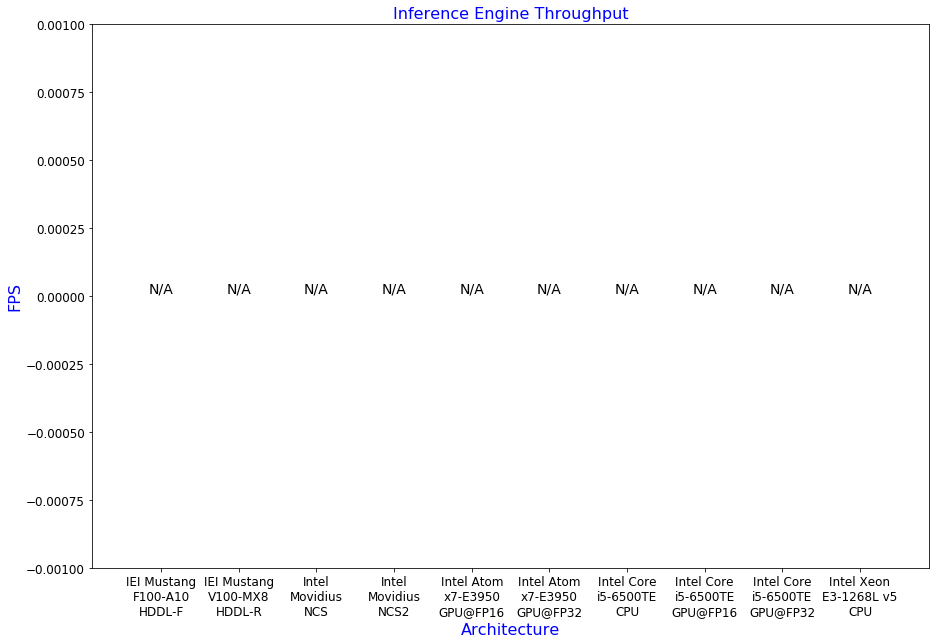

In [4]:
arch_dict = {'core':     'Intel Core\ni5-6500TE\nCPU',
             'gpu':      'Intel Core\ni5-6500TE\nGPU@FP32',
             'gpu_half': 'Intel Core\ni5-6500TE\nGPU@FP16',
             'xeon':     'Intel Xeon\nE3-1268L v5\nCPU',
             'ncs':      'Intel\nMovidius\nNCS',
             'ncs2':     'Intel\nMovidius\nNCS2',
             'hddlr':    'IEI Mustang\nV100-MX8\nHDDL-R',
             'fpga':     'IEI Mustang\nF100-A10\nHDDL-F',
             'up2':      'Intel Atom\nx7-E3950\nGPU@FP32',
             'up2_half': 'Intel Atom\nx7-E3950\nGPU@FP16'}

stats_dict = {}
for arch,a_name in arch_dict.items():
    if 'job_id_' + arch in vars():
        stats_dict['results/stats_' + vars()['job_id_' + arch][0] + '.txt'] = a_name
    else:
        stats_dict['placeholder' + arch] = a_name

summaryPlot(stats_dict, 'Architecture', 'FPS', 'Inference Throughput', fontsize=12)